# Visualize graph obtained from pycausal analysis

In [144]:
import pandas as pd
import pycausal
from pycausal import pycausal as pc
from pycausal import search as s
import networkx as nx
import glob
import os
from os.path import join as pjoin
from IPython.display import SVG
import pylab
import matplotlib.pyplot as plt

## functions to get graph

In [1]:
def getdfs(csvdir):
    """
    give us list of data frames for csv files in directory.
    """
    dfs = []
    for csvfile in glob.glob(csvdir + os.sep + "*.csv"):
        df = pd.read_csv(csvfile)
        dfs.append(df)
    return dfs

In [2]:
def run_images_lofs(dfs,
                    withlofs=True,
                    lofsrule='R3',
                    lofsscore='andersonDarling',
                    maxdegree=30,
                    penalty=4):
    """
    run IMaGES and optionally LOFS post-processing on a given list of dataframes.
    Return the graph instance of either images or lofs output.
    """
    pc.start_vm() 
    
    images = s.imagesSemBic(dfs, verbose=True, maxDegree=maxdegree, penaltyDiscount=penalty)
    if withlofs:
        tetradGraph = images.getTetradGraph()    
        lofs = s.lofs(tetradGraph, dfs, dataType=0, rule=lofsrule, score=lofsscore)
    
        pc.stop_vm()
        return lofs
    else:
        pc.stop_vm()
        return images

In [3]:
def plot_svg(images_instance):
    """
    Take graph instance from IMaGES or LOFS and plot the SVG.
    """
    dot = images_instance.getDot()
    svg_str = dot.create_svg(prog='dot')
    svg = SVG(svg_str)
    return svg

## run IMaGES + LOFS on residual data

In [13]:
dfs = getdfs(pjoin('/host', 'famfaces', 'extract_meants_nuisance', 'csv', 'run*'))

In [14]:
lofs = run_images_lofs(dfs)

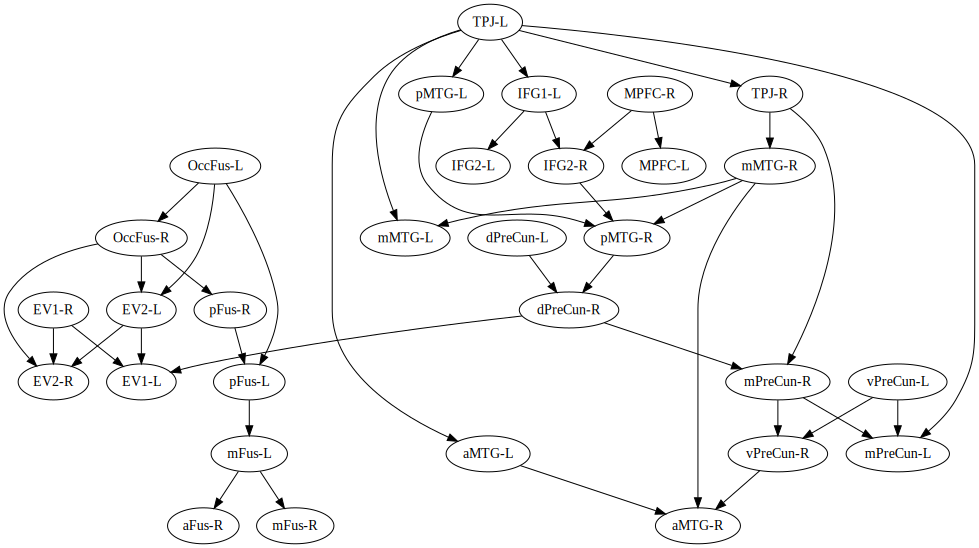

In [93]:
plot_svg(lofs)

## pycausal to networkx graph

In [5]:
def pc2nx(images_instance):
    """
    Take the result from IMaGES or IMaGES+LOFS and return
    a networkx directed multigraph.
    """
    G = nx.drawing.nx_pydot.from_pydot(images_instance.graph)
    return G

In [18]:
G = pc2nx(lofs)

## visualize with networkx

In [88]:
# create different node layouts/positions to try out
spring_pos = nx.spring_layout(G)
spec_pos = nx.spectral_layout(G)
rand_pos = nx.random_layout(G)
shell_pos = nx.shell_layout(G) # same as circular
circ_pos = nx.circular_layout(G)

In [82]:
# get real ROI coordinates

def create_posdict(infile):
    """
    Create dictionary with node name as key and XY coordinates
    as values from a CSV file
    """
    import csv
    import numpy as np
    
    # read csv file
    with open(infile, 'rb') as csvfile:
        rdr = csv.reader(csvfile, delimiter=',')
        data = [row for row in rdr]

    # seperate nodes and coordinates
    xy = np.array([map(int, row[1:-1]) for row in data[1:]])
    nodes = [row[0].replace(' ', '') for row in data[1:]]

    # map to dict
    posdict = dict()
    for node, coord in zip(nodes, xy):
        posdict[node] = coord
    
    return posdict

In [109]:
coords_file = '/host/famfaces/rois/tetrad/roi_coord_30.csv'
roi_pos = create_posdict(coords_file)
#print(roi_pos)

In [134]:
# node colors based on core/extended system

nodecolors = []

for node in roi_pos.keys():
    if 'EV' in node:
        nodecolors.append('blue')
    elif 'Fus' in node:
        nodecolors.append( 'red')
    elif 'MPFC' in node or 'TPJ' in node:
        nodecolors.append('green')
    elif 'IFG' in node:
        nodecolors.append('orange')
    elif 'MTG' in node:
        nodecolors.append('brown')
    elif 'PreCun' in node:
        nodecolors.append('cyan')
    else:
        nodecolors.append('black') # fallback

In [152]:
# adjust style with seaborn
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

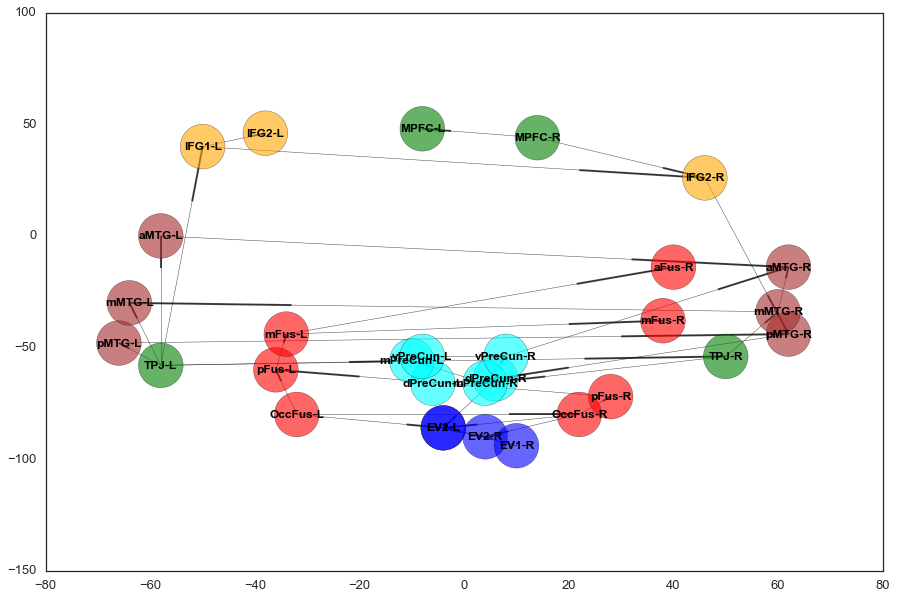

In [170]:
# initiate figure
plt.figure(3,figsize=(15,10)) 

# draw nodes, edges and labels
nx.draw_networkx_nodes(G, pos=roi_pos, node_size=2000, node_color=nodecolors, alpha=0.6)
nx.draw_networkx_edges(G, pos=roi_pos, alpha=0.7, arrows=True, width=.5)
nx.draw_networkx_labels(G, pos=roi_pos, font_size=12, font_family='sans-serif', font_weight='bold')

plt.show()

In [167]:
# nx.draw?

In [168]:
# nx.draw_networkx?